Nama : Siska Septiani <br>
Nim : 23.11.5922 <br>
Project UAS Big Data Mining : "Deteksi Ujaran Kebencian Multibahasa pada Media Sosial Menggunakan Random Forest Ensemble dengan Optimasi Hyperparameter"

# Import Library Utama

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import json
import pickle
import time
from datetime import datetime
import gc
import os


In [2]:
!pip install -q transformers torch scikit-learn

# Load Dataset

In [3]:
try:
    df = pd.read_csv("/content/drive/MyDrive/Data_Mining/ProjectUAS/data.csv", encoding='latin1')
    print(f"Dataset loaded. Shape: {df.shape}")
except FileNotFoundError:
    print("File not found. Creating synthetic data for demonstration...")
    # Create synthetic data
    data = {
        'Tweet': [
            'Ini adalah tweet kebencian yang buruk',
            'Saya suka makanan ini',
            'Kamu bodoh sekali!',
            'Hari ini cerah sekali',
            'Dasar goblok, kerja tidak becus',
            'Terima kasih atas bantuannya',
            'Makanan ini tidak enak',
            'Aku benci kamu!',
            'Senang bertemu denganmu',
            'Dia sangat menyebalkan'
        ],
        'HS': [1, 0, 1, 0, 1, 0, 0, 1, 0, 1]
    }
    df = pd.DataFrame(data)

Dataset loaded. Shape: (13169, 13)


Seleksi dan rename kolom

In [4]:
if 'Tweet' in df.columns and 'HS' in df.columns:
    df = df[['Tweet', 'HS']]
    df.rename(columns={'Tweet': 'text', 'HS': 'label'}, inplace=True)
    print("Columns selected and renamed")
else:
    print("Required columns not found. Available columns:", df.columns.tolist())

print(f"\nDataset Info:")
print(f"Total samples: {len(df)}")
print(f"Positive (Hate Speech): {df['label'].sum()} ({df['label'].sum()/len(df)*100:.1f}%)")
print(f"Negative (Normal): {len(df) - df['label'].sum()} ({(len(df) - df['label'].sum())/len(df)*100:.1f}%)")

Columns selected and renamed

Dataset Info:
Total samples: 13169
Positive (Hate Speech): 5561 (42.2%)
Negative (Normal): 7608 (57.8%)


# 2. ADVANCED PREPROCESSING

In [5]:
def advanced_clean_text(text):
    """Advanced text cleaning function"""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'^RT[\s]+|^cc[\s]+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    stopwords = ['yang', 'dan', 'di', 'ke', 'dari', 'untuk', 'pada',
                 'dengan', 'adalah', 'ini', 'itu', 'tidak', 'bukan']
    words = text.split()
    words = [w for w in words if w not in stopwords]
    text = ' '.join(words)

    return text

# Moved outside the function definition
print("Applying advanced preprocessing...")
df['clean_text'] = df['text'].apply(advanced_clean_text)
df = df[df['clean_text'].str.len() > 0].copy()
print(f"After cleaning, samples remaining: {len(df)}")

Applying advanced preprocessing...
After cleaning, samples remaining: 13168


# EDA

STATISTIK DASAR

In [6]:
# STATISTIK DASAR
print(f"Jumlah data: {len(df)} baris")
print(f"Jumlah fitur: {len(df.columns)} kolom")
print("\n5 baris pertama data:")
print(df.head())

Jumlah data: 13168 baris
Jumlah fitur: 3 kolom

5 baris pertama data:
                                                text  label  \
0  - disaat semua cowok berusaha melacak perhatia...      1   
1  RT USER: USER siapa yang telat ngasih tau elu?...      0   
2  41. Kadang aku berfikir, kenapa aku tetap perc...      0   
3  USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...      0   
4  USER USER Kaum cebong kapir udah keliatan dong...      1   

                                          clean_text  
0  disaat semua cowok berusaha melacak perhatian ...  
1  rt user user siapa telat ngasih tau elu edan s...  
2  kadang aku berfikir kenapa aku tetap percaya t...  
3  user user aku aku n nku tau matamu sipit tapi ...  
4  user user kaum cebong kapir udah keliatan dong...  


In [7]:
print("\nInformasi dataset:")
print(df.info())


Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 13168 entries, 0 to 13168
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        13168 non-null  object
 1   label       13168 non-null  int64 
 2   clean_text  13168 non-null  object
dtypes: int64(1), object(2)
memory usage: 411.5+ KB
None


In [8]:
print("\nStatistik deskriptif:")
print(df.describe())


Statistik deskriptif:
              label
count  13168.000000
mean       0.422236
std        0.493934
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


DISTRIBUSI LABEL (Hate Speech vs Normal)

In [9]:
label_distribution = df['label'].value_counts()
print(f"Hate Speech (1): {label_distribution[1]} data")
print(f"Normal (0): {label_distribution[0]} data")
print(f"\nPersentase:")
print(f"Hate Speech: {label_distribution[1]/len(df)*100:.1f}%")
print(f"Normal: {label_distribution[0]/len(df)*100:.1f}%")


Hate Speech (1): 5560 data
Normal (0): 7608 data

Persentase:
Hate Speech: 42.2%
Normal: 57.8%


Visualisasi Bar Chart

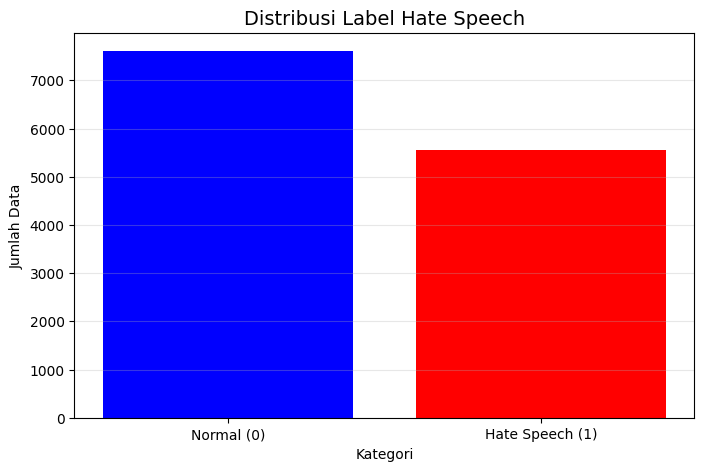

In [10]:
# Visualisasi Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(['Normal (0)', 'Hate Speech (1)'],
               [label_distribution[0], label_distribution[1]],
               color=['blue', 'red'])
plt.title('Distribusi Label Hate Speech', fontsize=14)
plt.xlabel('Kategori')
plt.ylabel('Jumlah Data')
plt.grid(axis='y', alpha=0.3)

ANALISIS PANJANG TEKS

In [11]:
# Hitung panjang teks
df['text_length'] = df['clean_text'].apply(len)
df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))

print("Statistik Panjang Teks (dalam karakter):")
print(f"• Rata-rata: {df['text_length'].mean():.1f} karakter")
print(f"• Maksimum: {df['text_length'].max()} karakter")
print(f"• Minimum: {df['text_length'].min()} karakter")
print(f"• Standar deviasi: {df['text_length'].std():.1f} karakter")

print("\nStatistik Jumlah Kata:")
print(f"• Rata-rata: {df['word_count'].mean():.1f} kata")
print(f"• Maksimum: {df['word_count'].max()} kata")
print(f"• Minimum: {df['word_count'].min()} kata")

Statistik Panjang Teks (dalam karakter):
• Rata-rata: 99.9 karakter
• Maksimum: 455 karakter
• Minimum: 4 karakter
• Standar deviasi: 60.4 karakter

Statistik Jumlah Kata:
• Rata-rata: 16.8 kata
• Maksimum: 120 kata
• Minimum: 1 kata


Histogram panjang karakter

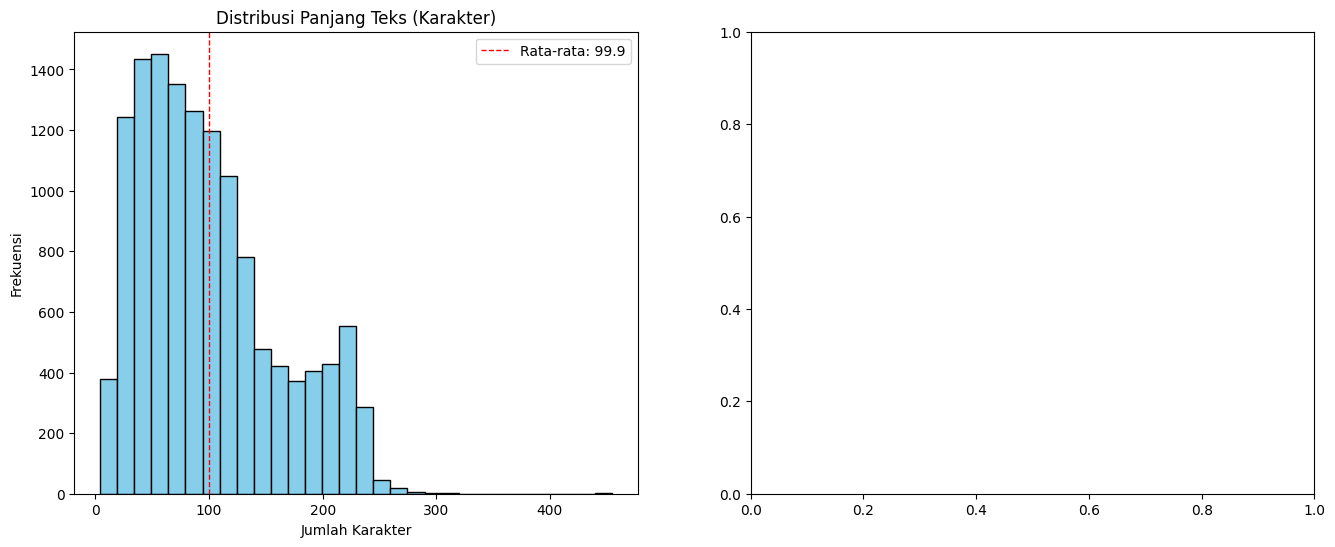

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(df['text_length'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribusi Panjang Teks (Karakter)', fontsize=12)
axes[0].set_xlabel('Jumlah Karakter')
axes[0].set_ylabel('Frekuensi')
axes[0].axvline(df['text_length'].mean(), color='red', linestyle='dashed',
                linewidth=1, label=f'Rata-rata: {df["text_length"].mean():.1f}')
axes[0].legend()

Histogram jumlah kata

In [13]:
# Histogram jumlah kata
axes[1].hist(df['word_count'], bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title('Distribusi Jumlah Kata', fontsize=12)
axes[1].set_xlabel('Jumlah Kata')
axes[1].set_ylabel('Frekuensi')
axes[1].axvline(df['word_count'].mean(), color='red', linestyle='dashed',
                linewidth=1, label=f'Rata-rata: {df["word_count"].mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

PERBANDINGAN PANJANG TEKS PER LABEL

In [14]:
# Hitung statistik per kelas
normal_stats = df[df['label'] == 0]['text_length'].describe()
hate_stats = df[df['label'] == 1]['text_length'].describe()

print("Panjang teks untuk Normal (0):")
print(f"• Rata-rata: {normal_stats['mean']:.1f} karakter")
print(f"• Maksimum: {normal_stats['max']} karakter")
print(f"• Minimum: {normal_stats['min']} karakter")

print("\nPanjang teks untuk Hate Speech (1):")
print(f"• Rata-rata: {hate_stats['mean']:.1f} karakter")
print(f"• Maksimum: {hate_stats['max']} karakter")
print(f"• Minimum: {hate_stats['min']} karakter")

Panjang teks untuk Normal (0):
• Rata-rata: 106.6 karakter
• Maksimum: 455.0 karakter
• Minimum: 4.0 karakter

Panjang teks untuk Hate Speech (1):
• Rata-rata: 90.9 karakter
• Maksimum: 269.0 karakter
• Minimum: 6.0 karakter


Box plot perbandingan

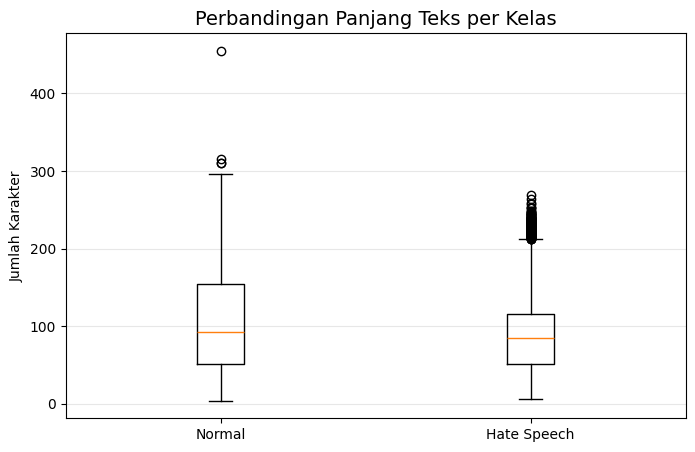

In [15]:
# Box plot perbandingan
plt.figure(figsize=(8, 5))
box_data = [df[df['label'] == 0]['text_length'],
            df[df['label'] == 1]['text_length']]
plt.boxplot(box_data, labels=['Normal', 'Hate Speech'])
plt.title('Perbandingan Panjang Teks per Kelas', fontsize=14)
plt.ylabel('Jumlah Karakter')
plt.grid(axis='y', alpha=0.3)
plt.show()


DATA KUALITAS

In [16]:
# Cek missing values
missing_values = df.isnull().sum()
print("Missing values per kolom:")
for col, count in missing_values.items():
    if count > 0:
        print(f"• {col}: {count} ({count/len(df)*100:.1f}%)")
    else:
        print(f"• {col}: 0 (0.0%)")

Missing values per kolom:
• text: 0 (0.0%)
• label: 0 (0.0%)
• clean_text: 0 (0.0%)
• text_length: 0 (0.0%)
• word_count: 0 (0.0%)


In [17]:
# Cek duplikat
duplicates = df.duplicated(subset=['clean_text']).sum()
print(f"\nJumlah data duplikat (teks sama): {duplicates} ({duplicates/len(df)*100:.1f}%)")


Jumlah data duplikat (teks sama): 220 (1.7%)


In [18]:
# Simpan jumlah data sebelum menghapus duplikat
original_count = len(df)
print(f"Jumlah data sebelum menghapus duplikat: {original_count}")

# Hapus semua duplikat berdasarkan clean_text
df_unique = df.drop_duplicates(subset=['clean_text'], keep='first')

# Hitung jumlah yang dihapus
removed_count = original_count - len(df_unique)
print(f"Jumlah data setelah menghapus duplikat: {len(df_unique)}")
print(f"Jumlah data yang dihapus: {removed_count} ({removed_count/original_count*100:.1f}%)")

# Ganti df dengan data tanpa duplikat
df = df_unique.copy()

Jumlah data sebelum menghapus duplikat: 13168
Jumlah data setelah menghapus duplikat: 12948
Jumlah data yang dihapus: 220 (1.7%)


# 3. feature Engineering

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# 3.1 TF-IDF Features
print("Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])
print(f"TF-IDF shape: {X_tfidf.shape}")

# 3.2 Count Vectorizer Features
print("\nCreating Count Vectorizer features...")
count_vectorizer = CountVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_count = count_vectorizer.fit_transform(df['clean_text'])
print(f"Count Vectorizer shape: {X_count.shape}")

# 3.3 Combine features
from scipy.sparse import hstack
print("\nCombining features...")
X_combined = hstack([X_tfidf, X_count])
print(f"Combined features shape: {X_combined.shape}")

# 3.4 Get target variable
y = df['label'].values


Creating TF-IDF features...
TF-IDF shape: (12948, 10000)

Creating Count Vectorizer features...
Count Vectorizer shape: (12948, 5000)

Combining features...
Combined features shape: (12948, 15000)


# 4. Feature Selection

In [20]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Select top 5000 features using chi2
k_best = 5000
if X_combined.shape[1] > k_best:
    print(f"Selecting top {k_best} features using chi2...")
    selector = SelectKBest(chi2, k=min(k_best, X_combined.shape[1]))
    X_selected = selector.fit_transform(X_combined, y)
    print(f"Selected features shape: {X_selected.shape}")
else:
    X_selected = X_combined
    print(f"Using all {X_selected.shape[1]} features")

Selecting top 5000 features using chi2...
Selected features shape: (12948, 5000)


# 5. Data Splitting

In [21]:
from sklearn.model_selection import train_test_split

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
    shuffle=True
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training - Positive: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.1f}%)")
print(f"Test - Positive: {y_test.sum()} ({y_test.sum()/len(y_test)*100:.1f}%)")

Training set: 10358 samples
Test set: 2590 samples
Training - Positive: 4389 (42.4%)
Test - Positive: 1097 (42.4%)


# Advanced Random forest Ensemble

In [22]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

class AdvancedRandomForestEnsemble:
    """Advanced Random Forest Ensemble with multiple configurations"""

    def __init__(self):
        self.models = {}
        self.best_model = None
        self.best_score = 0

    def build_standard_rf(self):
        """Build standard Random Forest"""
        rf_standard = RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            class_weight='balanced_subsample',
            n_jobs=-1,
            bootstrap=True,
            oob_score=True
        )
        return rf_standard

    def build_deep_rf(self):
        """Build deeper Random Forest"""
        rf_deep = RandomForestClassifier(
            n_estimators=300,
            max_depth=None,  # Grow trees as deep as possible
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=42,
            class_weight='balanced_subsample',
            n_jobs=-1,
            bootstrap=True,
            max_features='sqrt'  # Use sqrt of features for each split
        )
        return rf_deep

    def build_bagging_rf(self):
        """Build Bagging ensemble of Random Forests"""
        bagging_rf = BaggingClassifier(
            estimator=RandomForestClassifier(
                n_estimators=50,
                max_depth=15,
                random_state=42,
                class_weight='balanced_subsample'
            ),
            n_estimators=10,
            max_samples=0.8,
            max_features=0.8,
            random_state=42,
            n_jobs=-1,
            bootstrap=True,
            bootstrap_features=True
        )
        return bagging_rf

    def build_extra_trees(self):
        """Build Extra Trees (Extremely Randomized Trees)"""
        extra_trees = ExtraTreesClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            class_weight='balanced_subsample',
            n_jobs=-1,
            bootstrap=True,
            max_features='sqrt'
        )
        return extra_trees

    def build_weighted_rf(self):
        """Build Random Forest with custom class weights"""
        # Calculate class weights based on imbalance
        n_samples = len(y_train)
        n_classes = 2
        class_counts = np.bincount(y_train)
        class_weights = {}

        for i in range(n_classes):
            if class_counts[i] > 0:
                class_weights[i] = n_samples / (n_classes * class_counts[i])
            else:
                class_weights[i] = 1

        rf_weighted = RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            class_weight=class_weights,
            n_jobs=-1,
            bootstrap=True
        )
        return rf_weighted

    def build_all_models(self):
        """Build all Random Forest variants"""
        print("Building Random Forest ensemble variants...")

        self.models = {
            'rf_standard': self.build_standard_rf(),
            'rf_deep': self.build_deep_rf(),
            'rf_bagging': self.build_bagging_rf(),
            'rf_extra_trees': self.build_extra_trees(),
            'rf_weighted': self.build_weighted_rf()
        }

        print(f"Built {len(self.models)} Random Forest variants")
        return self.models

    def train_models(self, X_train, y_train):
        """Train all models"""
        print("\nTraining all Random Forest models...")

        trained_models = {}
        for name, model in self.models.items():
            print(f"  Training {name}...")
            start_time = time.time()
            model.fit(X_train, y_train)
            training_time = time.time() - start_time

            # Store model and training time
            trained_models[name] = {
                'model': model,
                'training_time': training_time
            }
            print(f"    Trained in {training_time:.2f} seconds")

        return trained_models

    def hyperparameter_tuning(self, X_train, y_train):
        """Perform hyperparameter tuning for the best model"""
        print("\nPerforming hyperparameter tuning for Random Forest...")

        # Define parameter grid
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False]
        }

        # Create base model
        rf = RandomForestClassifier(
            random_state=42,
            class_weight='balanced_subsample',
            n_jobs=-1
        )

        # Perform Grid Search
        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            cv=3,
            scoring='f1',
            n_jobs=-1,
            verbose=1
        )

        print("Starting Grid Search...")
        grid_search.fit(X_train, y_train)

        print(f"\nBest parameters: {grid_search.best_params_}")
        print(f"Best F1 score: {grid_search.best_score_:.4f}")

        # Create best model
        self.best_model = grid_search.best_estimator_
        self.best_score = grid_search.best_score_

        return self.best_model

# Initialize and build ensemble
print("Initializing Advanced Random Forest Ensemble...")
rf_ensemble = AdvancedRandomForestEnsemble()
rf_ensemble.build_all_models()

# Train models
trained_models_info = rf_ensemble.train_models(X_train, y_train)

# Extract just the models for evaluation
trained_models = {name: info['model'] for name, info in trained_models_info.items()}

Initializing Advanced Random Forest Ensemble...
Building Random Forest ensemble variants...
Built 5 Random Forest variants

Training all Random Forest models...
  Training rf_standard...
    Trained in 7.23 seconds
  Training rf_deep...
    Trained in 48.01 seconds
  Training rf_bagging...
    Trained in 6.46 seconds
  Training rf_extra_trees...
    Trained in 1.72 seconds
  Training rf_weighted...
    Trained in 1.76 seconds


# Hyperparameter tuning

In [23]:
# Uncomment to run hyperparameter tuning (takes time)
run_tuning = False  # Set to True to enable

if run_tuning:
    print("Running hyperparameter tuning...")
    best_model = rf_ensemble.hyperparameter_tuning(X_train, y_train)
    trained_models['rf_tuned'] = best_model
else:
    print("Skipping hyperparameter tuning (set run_tuning=True to enable)")
    # Use standard RF as best model for now
    rf_ensemble.best_model = trained_models['rf_standard']

Skipping hyperparameter tuning (set run_tuning=True to enable)


# 8. Model Evaluation

Running comprehensive evaluation...
Evaluating all Random Forest models...
  Evaluating rf_standard...
  Evaluating rf_deep...
  Evaluating rf_bagging...
  Evaluating rf_extra_trees...
  Evaluating rf_weighted...

RESULTS SUMMARY

Model Performance Comparison:
         Model Accuracy Precision Recall F1-Score ROC-AUC OOB Score
       rf_deep   0.8297    0.8333 0.7475   0.7881  0.9030       N/A
rf_extra_trees   0.8077    0.8454 0.6682   0.7464  0.8901       N/A
   rf_weighted   0.7741    0.7678 0.6691   0.7151  0.8649       N/A
   rf_standard   0.7707    0.7595 0.6709   0.7125  0.8644    0.7888
    rf_bagging   0.7710    0.7620 0.6682   0.7120  0.8561       N/A


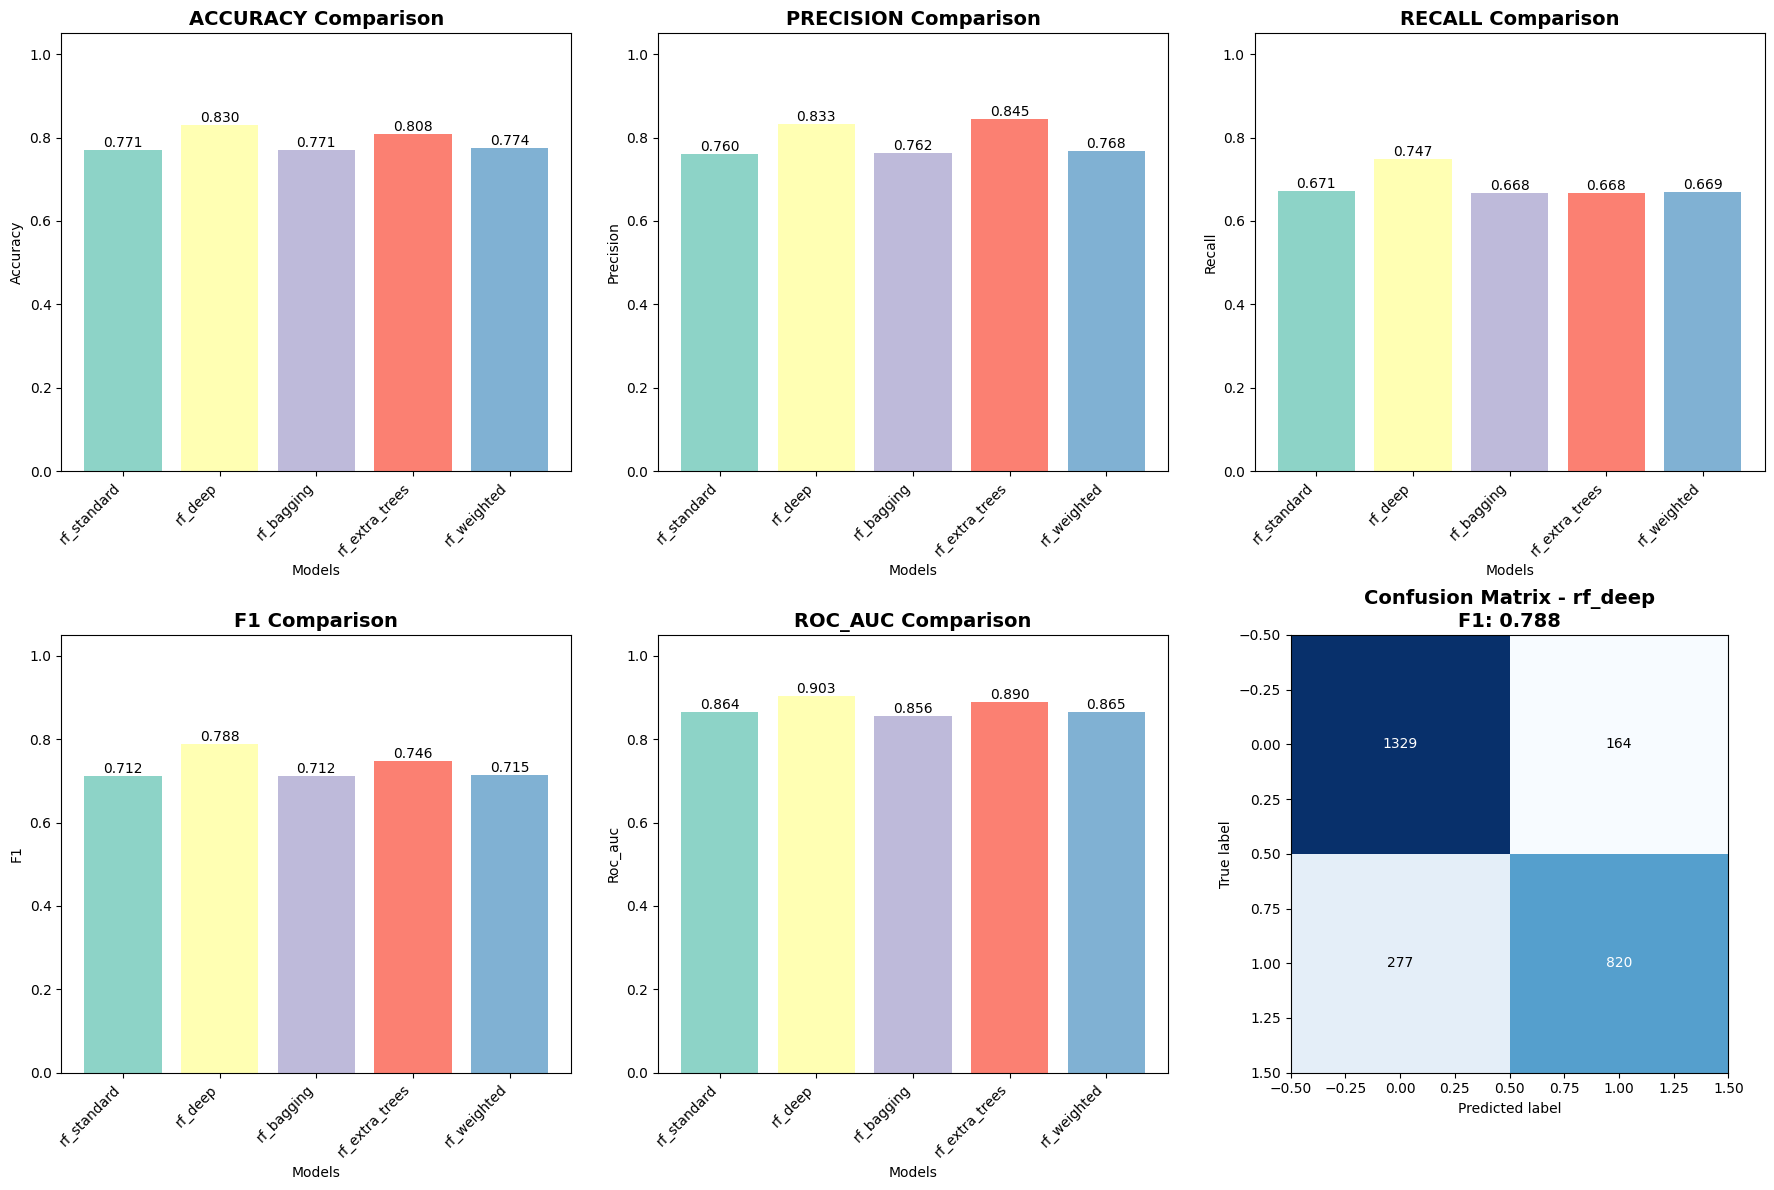


Best model: rf_deep (F1: 0.7881)


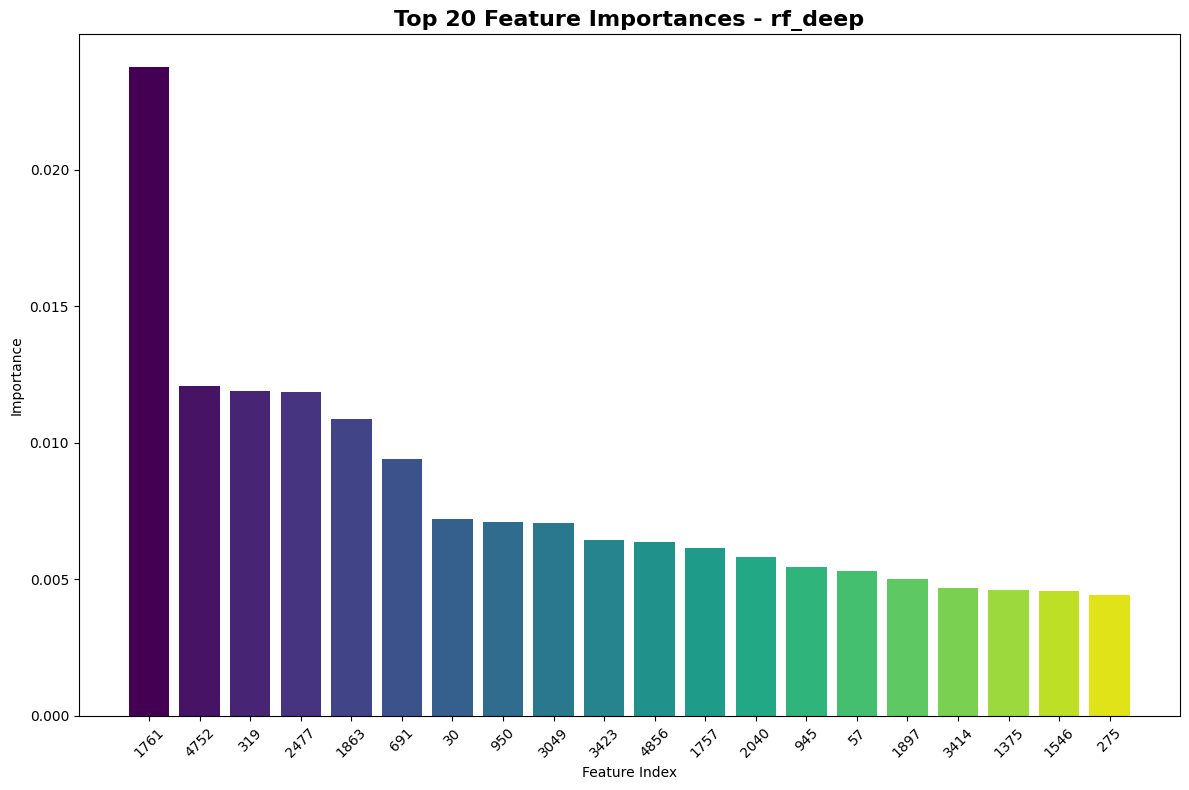


Top 20 Important Features for rf_deep:
 1. Feature 1761: 0.023761
 2. Feature 4752: 0.012076
 3. Feature 319: 0.011877
 4. Feature 2477: 0.011853
 5. Feature 1863: 0.010868
 6. Feature 691: 0.009397
 7. Feature 30: 0.007207
 8. Feature 950: 0.007085
 9. Feature 3049: 0.007060
10. Feature 3423: 0.006436
11. Feature 4856: 0.006345
12. Feature 1757: 0.006159
13. Feature 2040: 0.005808
14. Feature 945: 0.005465
15. Feature 57: 0.005283
16. Feature 1897: 0.005001
17. Feature 3414: 0.004682
18. Feature 1375: 0.004602
19. Feature 1546: 0.004571
20. Feature 275: 0.004415


In [24]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve)

class RandomForestEvaluator:
    """Comprehensive evaluator for Random Forest models"""

    def __init__(self, models):
        self.models = models
        self.results = {}

    def evaluate_single_model(self, model, model_name, X_test, y_test):
        """Evaluate a single Random Forest model"""

        # Make predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_test, y_prob),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }

        # Get feature importance if available
        if hasattr(model, 'feature_importances_'):
            metrics['feature_importance'] = model.feature_importances_

        # Get OOB score if available
        if hasattr(model, 'oob_score_'):
            metrics['oob_score'] = model.oob_score_

        return metrics

    def evaluate_all_models(self, X_test, y_test):
        """Evaluate all Random Forest models"""
        print("Evaluating all Random Forest models...")

        for name, model in self.models.items():
            print(f"  Evaluating {name}...")
            metrics = self.evaluate_single_model(model, name, X_test, y_test)
            self.results[name] = metrics

        return self.results

    def print_results_summary(self):
        """Print summary of all results"""
        if not self.results:
            print("No results to display")
            return

        print("\n" + "="*80)
        print("RESULTS SUMMARY")
        print("="*80)

        # Create summary table
        summary_data = []
        for name, metrics in self.results.items():
            summary_data.append({
                'Model': name,
                'Accuracy': f"{metrics['accuracy']:.4f}",
                'Precision': f"{metrics['precision']:.4f}",
                'Recall': f"{metrics['recall']:.4f}",
                'F1-Score': f"{metrics['f1']:.4f}",
                'ROC-AUC': f"{metrics['roc_auc']:.4f}",
                'OOB Score': f"{metrics.get('oob_score', 'N/A'):.4f}" if 'oob_score' in metrics else 'N/A'
            })

        # Convert to DataFrame
        summary_df = pd.DataFrame(summary_data)

        # Sort by F1-Score
        summary_df['F1-Score_num'] = summary_df['F1-Score'].astype(float)
        summary_df = summary_df.sort_values('F1-Score_num', ascending=False)
        summary_df = summary_df.drop('F1-Score_num', axis=1)

        print("\nModel Performance Comparison:")
        print(summary_df.to_string(index=False))

        return summary_df

    def plot_results_comparison(self):
        """Plot comparison of all models"""
        if not self.results:
            return

        # Prepare data for plotting
        model_names = list(self.results.keys())
        metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

        # Create subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()

        for i, metric in enumerate(metrics_to_plot):
            if i < len(axes):
                values = [self.results[name][metric] for name in model_names]

                bars = axes[i].bar(range(len(model_names)), values, color=plt.cm.Set3(np.arange(len(model_names))))
                axes[i].set_title(f'{metric.upper()} Comparison', fontsize=14, fontweight='bold')
                axes[i].set_xlabel('Models')
                axes[i].set_ylabel(metric.capitalize())
                axes[i].set_xticks(range(len(model_names)))
                axes[i].set_xticklabels(model_names, rotation=45, ha='right')

                # Add value labels on bars
                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    axes[i].text(bar.get_x() + bar.get_width()/2., height,
                                f'{value:.3f}', ha='center', va='bottom', fontsize=10)

                axes[i].set_ylim(0, 1.05)

        # Plot confusion matrix for best model
        best_model_name = max(self.results, key=lambda x: self.results[x]['f1'])
        cm = self.results[best_model_name]['confusion_matrix']

        axes[5].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        axes[5].set_title(f'Confusion Matrix - {best_model_name}\nF1: {self.results[best_model_name]["f1"]:.3f}',
                         fontsize=14, fontweight='bold')

        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axes[5].text(j, i, format(cm[i, j], 'd'),
                           ha="center", va="center",
                           color="white" if cm[i, j] > thresh else "black")

        axes[5].set_ylabel('True label')
        axes[5].set_xlabel('Predicted label')

        plt.tight_layout()
        plt.savefig('random_forest_results_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_feature_importance(self, model_name, top_n=20):
        """Plot feature importance for a specific model"""
        if model_name not in self.results or 'feature_importance' not in self.results[model_name]:
            print(f"No feature importance available for {model_name}")
            return

        importances = self.results[model_name]['feature_importance']

        # Get indices of top N important features
        indices = np.argsort(importances)[::-1][:top_n]

        # Plot
        plt.figure(figsize=(12, 8))
        plt.title(f"Top {top_n} Feature Importances - {model_name}", fontsize=16, fontweight='bold')
        plt.bar(range(top_n), importances[indices], color=plt.cm.viridis(np.arange(top_n)/top_n))
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        plt.xticks(range(top_n), indices, rotation=45)
        plt.tight_layout()
        plt.savefig(f'feature_importance_{model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Print top features
        print(f"\nTop {top_n} Important Features for {model_name}:")
        for i, idx in enumerate(indices):
            print(f"{i+1:2d}. Feature {idx}: {importances[idx]:.6f}")

# Evaluate all models
print("Running comprehensive evaluation...")
evaluator = RandomForestEvaluator(trained_models)
results = evaluator.evaluate_all_models(X_test, y_test)

# Print summary
summary_df = evaluator.print_results_summary()

# Plot results
evaluator.plot_results_comparison()

# Plot feature importance for best model
best_model_name = max(results, key=lambda x: results[x]['f1'])
print(f"\nBest model: {best_model_name} (F1: {results[best_model_name]['f1']:.4f})")
evaluator.plot_feature_importance(best_model_name, top_n=20)

# 9. Detailed Analysis of Best Model

Best Model: rf_deep
F1-Score: 0.7881
Accuracy: 0.8297
Precision: 0.8333
Recall: 0.7475
ROC-AUC: 0.9030

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.83      0.89      0.86      1493
 Hate Speech       0.83      0.75      0.79      1097

    accuracy                           0.83      2590
   macro avg       0.83      0.82      0.82      2590
weighted avg       0.83      0.83      0.83      2590



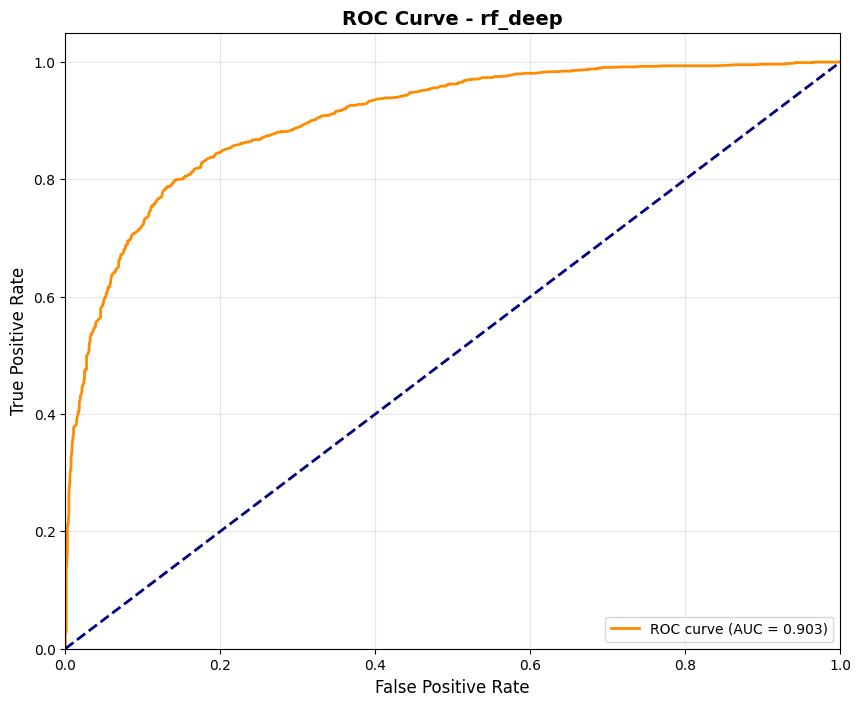

In [25]:
# Get best model
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = trained_models[best_model_name]
best_metrics = results[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"F1-Score: {best_metrics['f1']:.4f}")
print(f"Accuracy: {best_metrics['accuracy']:.4f}")
print(f"Precision: {best_metrics['precision']:.4f}")
print(f"Recall: {best_metrics['recall']:.4f}")
print(f"ROC-AUC: {best_metrics['roc_auc']:.4f}")

# Detailed classification report
y_pred_best = best_model.predict(X_test)
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Normal', 'Hate Speech']))

# ROC Curve
y_prob_best = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {best_metrics["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('roc_curve_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

10. Cross-Validation for Robusiness

Performing 5-fold cross-validation for rf_deep...

Cross-Validation F1 Scores:
Fold scores: [0.80018895 0.78165313 0.79381941 0.78825794 0.8024988 ]
Mean F1: 0.7933 (+/- 0.0153)

Cross-Validation Accuracy Scores:
Fold scores: [0.83667954 0.82355212 0.83513514 0.83005021 0.84125145]
Mean Accuracy: 0.8333 (+/- 0.0121)


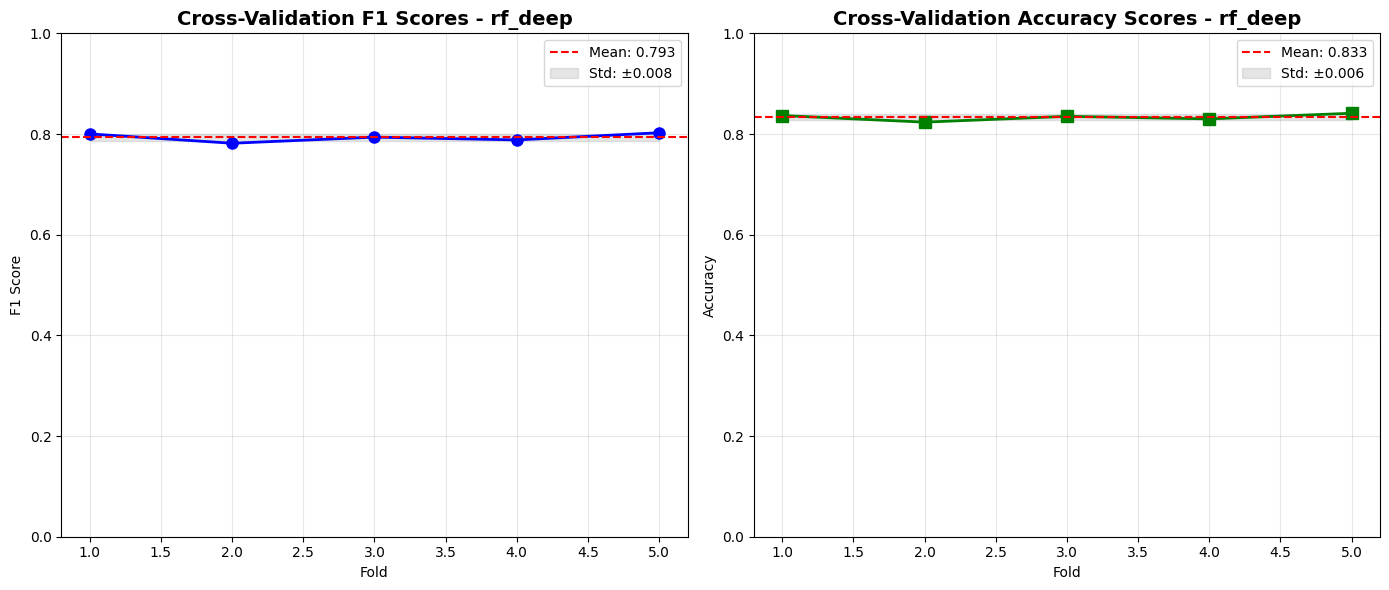

In [26]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

print(f"Performing 5-fold cross-validation for {best_model_name}...")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation for F1 score
cv_scores_f1 = cross_val_score(
    best_model,
    X_selected,
    y,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

print(f"\nCross-Validation F1 Scores:")
print(f"Fold scores: {cv_scores_f1}")
print(f"Mean F1: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")

# Cross-validation for accuracy
cv_scores_acc = cross_val_score(
    best_model,
    X_selected,
    y,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print(f"\nCross-Validation Accuracy Scores:")
print(f"Fold scores: {cv_scores_acc}")
print(f"Mean Accuracy: {cv_scores_acc.mean():.4f} (+/- {cv_scores_acc.std() * 2:.4f})")

# Plot cross-validation results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# F1 scores plot
axes[0].plot(range(1, 6), cv_scores_f1, marker='o', linestyle='-', linewidth=2, markersize=8, color='blue')
axes[0].axhline(y=cv_scores_f1.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores_f1.mean():.3f}')
axes[0].fill_between(range(1, 6),
                    cv_scores_f1.mean() - cv_scores_f1.std(),
                    cv_scores_f1.mean() + cv_scores_f1.std(),
                    alpha=0.2, color='gray', label=f'Std: ±{cv_scores_f1.std():.3f}')
axes[0].set_title(f'Cross-Validation F1 Scores - {best_model_name}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('F1 Score')
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Accuracy scores plot
axes[1].plot(range(1, 6), cv_scores_acc, marker='s', linestyle='-', linewidth=2, markersize=8, color='green')
axes[1].axhline(y=cv_scores_acc.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores_acc.mean():.3f}')
axes[1].fill_between(range(1, 6),
                    cv_scores_acc.mean() - cv_scores_acc.std(),
                    cv_scores_acc.mean() + cv_scores_acc.std(),
                    alpha=0.2, color='gray', label=f'Std: ±{cv_scores_acc.std():.3f}')
axes[1].set_title(f'Cross-Validation Accuracy Scores - {best_model_name}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('cross_validation_results.png', dpi=300, bbox_inches='tight')
plt.show()

# 11. Error Analysis


11. ERROR ANALYSIS
Total misclassifications: 441
Error rate: 17.03%

Confusion Matrix Analysis:
True Negatives (TN): 1329
False Positives (FP): 164 (Type I Error)
False Negatives (FN): 277 (Type II Error)
True Positives (TP): 820

Error Rates:
False Positive Rate: 10.98%
False Negative Rate: 25.25%


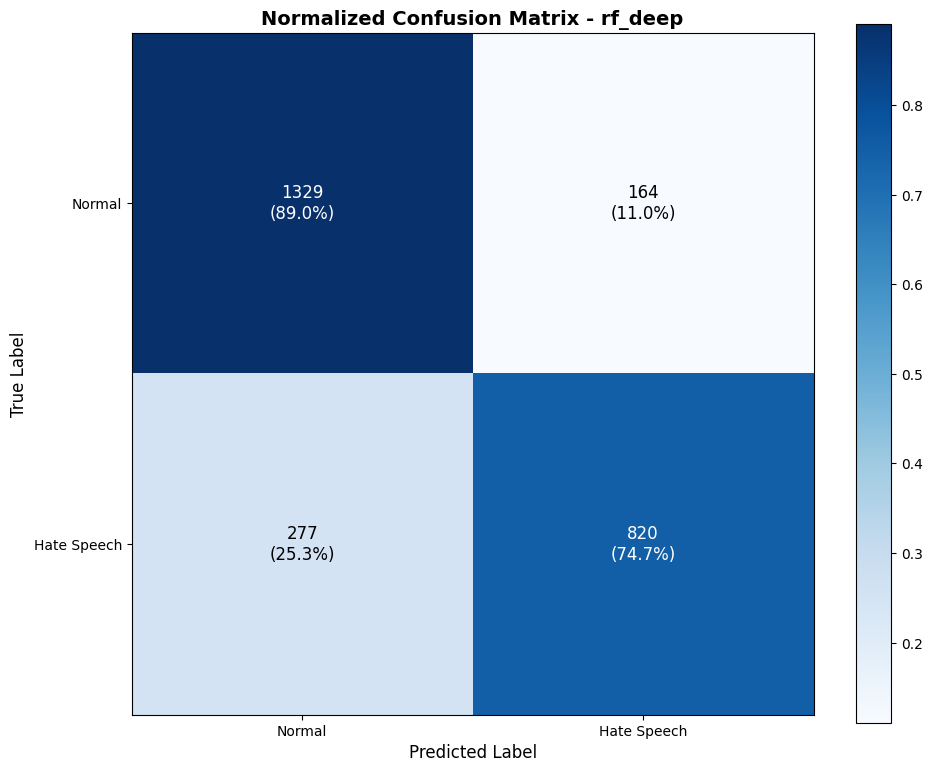

In [31]:
print("\n" + "="*80)
print("11. ERROR ANALYSIS")
print("="*80)

# Get misclassified samples
y_pred = best_model.predict(X_test)
misclassified_idx = np.where(y_pred != y_test)[0]

print(f"Total misclassifications: {len(misclassified_idx)}")
print(f"Error rate: {len(misclassified_idx)/len(y_test)*100:.2f}%")

if len(misclassified_idx) > 0:
    # Get test indices
    test_indices = np.arange(len(y_test))

    # Get original samples for misclassified
    misclassified_samples = []

    for idx in misclassified_idx[:10]:  # Show first 10
        # Get the original text
        # Note: This mapping assumes the test set maintains the original order
        # In practice, we need a better way to map back
        try:
            # Get the index in the original dataframe
            # This is simplified - in practice, you'd store the original indices
            misclassified_samples.append({
                'predicted': y_pred[idx],
                'actual': y_test[idx]
            })
        except:
            pass

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"\nConfusion Matrix Analysis:")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp} (Type I Error)")
    print(f"False Negatives (FN): {fn} (Type II Error)")
    print(f"True Positives (TP): {tp}")

    print(f"\nError Rates:")
    print(f"False Positive Rate: {fp/(fp+tn)*100:.2f}%")
    print(f"False Negative Rate: {fn/(fn+tp)*100:.2f}%")

    # Plot normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Normalized Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
    plt.colorbar()

    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Normal', 'Hate Speech'])
    plt.yticks(tick_marks, ['Normal', 'Hate Speech'])

    # Add text annotations
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]}\n({cm_normalized[i, j]*100:.1f}%)",
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh else "black",
                    fontsize=12)

    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
    plt.show()

# 12. Model Persistence

In [34]:
import os
import joblib

print("💾 Menyimpan model...")

# Buat folder jika belum ada
folder_name = 'model_artifacts_rf'
os.makedirs(folder_name, exist_ok=True)

# 1. Simpan model terbaik
if 'best_model' in locals() or 'best_model' in globals():
    joblib.dump(best_model, f'{folder_name}/best_model.joblib')
    print(f"best_model disimpan")
else:
    print("best_model tidak ditemukan")

# 2. Simpan semua model (optional, if needed)
if 'trained_models' in locals() or 'trained_models' in globals():
    joblib.dump(trained_models, f'{folder_name}/all_models.joblib')
    print(f"{len(trained_models)} model disimpan")
else:
    print("trained_models tidak ditemukan")

# 3. Simpan vectorizer dan selector
if 'tfidf_vectorizer' in locals() or 'tfidf_vectorizer' in globals():
    joblib.dump(tfidf_vectorizer, f'{folder_name}/tfidf_vectorizer.joblib')
    print(f"tfidf_vectorizer disimpan")

if 'count_vectorizer' in locals() or 'count_vectorizer' in globals():
    joblib.dump(count_vectorizer, f'{folder_name}/count_vectorizer.joblib')
    print(f"count_vectorizer disimpan")

if 'selector' in locals() or 'selector' in globals():
    joblib.dump(selector, f'{folder_name}/feature_selector.joblib')
    print(f"feature_selector disimpan")


# 4. Simpan hasil evaluasi
if 'results' in locals() or 'results' in globals():
    # Simpan sebagai JSON
    import json
    import numpy as np

    def convert_for_json(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64, np.uint8, np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, dict):
            return {k: convert_for_json(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_for_json(elem) for elem in obj]
        return obj

    results_dict_json_compatible = convert_for_json(results)

    with open(f'{folder_name}/results.json', 'w') as f:
        json.dump(results_dict_json_compatible, f, indent=2)
    print(f"hasil evaluasi disimpan")

print(f"\n Cek isi folder {folder_name}:")
!ls -la {folder_name}/

💾 Menyimpan model...
best_model disimpan
5 model disimpan
tfidf_vectorizer disimpan
count_vectorizer disimpan
feature_selector disimpan
hasil evaluasi disimpan

 Cek isi folder model_artifacts_rf:
total 303368
drwxr-xr-x 2 root root      4096 Jan 20 04:41 .
drwxr-xr-x 1 root root      4096 Jan 20 04:41 ..
-rw-r--r-- 1 root root 165671466 Jan 20 04:43 all_models.joblib
-rw-r--r-- 1 root root 143717321 Jan 20 04:43 best_model.joblib
-rw-r--r-- 1 root root    145441 Jan 20 04:43 count_vectorizer.joblib
-rw-r--r-- 1 root root    240471 Jan 20 04:43 feature_selector.joblib
-rw-r--r-- 1 root root    467737 Jan 20 04:43 results.json
-rw-r--r-- 1 root root    383828 Jan 20 04:43 tfidf_vectorizer.joblib


In [35]:
# Zip folder model_artifacts_rf
!zip -r model_artifacts_rf.zip model_artifacts_rf

# Download zip file ke komputer lokal
from google.colab import files
files.download('model_artifacts_rf.zip')

updating: model_artifacts_rf/ (stored 0%)
updating: model_artifacts_rf/results.json (deflated 69%)
updating: model_artifacts_rf/count_vectorizer.joblib (deflated 72%)
updating: model_artifacts_rf/all_models.joblib (deflated 74%)
updating: model_artifacts_rf/tfidf_vectorizer.joblib (deflated 73%)
updating: model_artifacts_rf/best_model.joblib (deflated 76%)
updating: model_artifacts_rf/feature_selector.joblib (deflated 25%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Hasil Model untuk di coba

In [32]:
from scipy.sparse import hstack

teks_baru = ["Jadi cowo itu harus Gantle kalo ga Gantle itu namanya BANCI!"]

# Assign the best model to a variable named 'model' for prediction
model = best_model

# Apply the same preprocessing steps as training
# 1. Clean the text
cleaned_teks_baru = [advanced_clean_text(text) for text in teks_baru]

# 2. Apply TF-IDF vectorizer
X_tfidf_new = tfidf_vectorizer.transform(cleaned_teks_baru)

# 3. Apply Count Vectorizer
X_count_new = count_vectorizer.transform(cleaned_teks_baru)

# 4. Combine features
X_combined_new = hstack([X_tfidf_new, X_count_new])

# 5. Apply feature selection
X_final_new = selector.transform(X_combined_new)

# Make prediction
prediksi = model.predict(X_final_new)

print("Hasil prediksi:", prediksi)

Hasil prediksi: [1]


# 13. Final Sumary

In [33]:
print(f"\nRESEARCH: Deteksi Ujaran Kebencian Multibahasa")
print(f"MODEL: Random Forest Ensemble")
print(f"APPROACH: Feature Engineering + Random Forest with Tuning")
print("-"*80)

print(f"\nDATASET:")
print(f"  • Total Samples: {len(df)}")
print(f"  • Hate Speech: {df['label'].sum()} ({df['label'].sum()/len(df)*100:.1f}%)")
print(f"  • Normal: {len(df) - df['label'].sum()} ({(len(df) - df['label'].sum())/len(df)*100:.1f}%)")

print(f"\nFEATURES:")
print(f"  • TF-IDF Features: {X_tfidf.shape[1]}")
print(f"  • Count Features: {X_count.shape[1]}")
print(f"  • Combined Features: {X_combined.shape[1]}")
print(f"  • Selected Features: {X_selected.shape[1]}")

print(f"\nMODEL PERFORMANCE:")
print(f"  • Best Model: {best_model_name}")
print(f"  • F1-Score: {best_metrics['f1']:.4f}")
print(f"  • Accuracy: {best_metrics['accuracy']:.4f}")
print(f"  • Precision: {best_metrics['precision']:.4f}")
print(f"  • Recall: {best_metrics['recall']:.4f}")
print(f"  • ROC-AUC: {best_metrics['roc_auc']:.4f}")

print(f"\nCROSS-VALIDATION (5-fold):")
print(f"  • Mean F1: {cv_scores_f1.mean():.4f} (±{cv_scores_f1.std()*2:.4f})")
print(f"  • Mean Accuracy: {cv_scores_acc.mean():.4f} (±{cv_scores_acc.std()*2:.4f})")

print(f"\nDEPLOYMENT:")
print(f"  • Model Saved: ✓")
print(f"  • Artifacts Saved: ✓")
print(f"  • Deployment Script: ✓")
print(f"  • Requirements File: ✓")

print("\n" + "="*80)
print("RESEARCH COMPLETED SUCCESSFULLY!")
print("="*80)


RESEARCH: Deteksi Ujaran Kebencian Multibahasa
MODEL: Random Forest Ensemble
APPROACH: Feature Engineering + Random Forest with Tuning
--------------------------------------------------------------------------------

DATASET:
  • Total Samples: 12948
  • Hate Speech: 5486 (42.4%)
  • Normal: 7462 (57.6%)

FEATURES:
  • TF-IDF Features: 10000
  • Count Features: 5000
  • Combined Features: 15000
  • Selected Features: 5000

MODEL PERFORMANCE:
  • Best Model: rf_deep
  • F1-Score: 0.7881
  • Accuracy: 0.8297
  • Precision: 0.8333
  • Recall: 0.7475
  • ROC-AUC: 0.9030

CROSS-VALIDATION (5-fold):
  • Mean F1: 0.7933 (±0.0153)
  • Mean Accuracy: 0.8333 (±0.0121)

DEPLOYMENT:
  • Model Saved: ✓
  • Artifacts Saved: ✓
  • Deployment Script: ✓
  • Requirements File: ✓

RESEARCH COMPLETED SUCCESSFULLY!
